In [275]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
from tqdm.notebook import tqdm
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
pyo.init_notebook_mode()
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import random
plt.rc('figure',figsize=(17,13))

In [134]:
trans = pd.read_csv('interview_transcripts_by_turkers.csv')
trans_c = trans.copy()
scores = pd.read_csv('turker_scores_full_interview.csv')
prosodic = pd.read_csv('prosodic_features.csv')
prosodic['participant&question'] = prosodic['participant&question'].apply(lambda x: x.split('Q')[0])
prosodic = prosodic.groupby(by='participant&question').mean().reset_index()
prosodic['participant&question'] = prosodic['participant&question'].str.lower()
prosodic = prosodic.set_index('participant&question')

In [135]:
def filter_interviewee(sir):
    dialog = sir.split('|')
    IW = [i for i in dialog if i.find('Interviewer') == -1]
    return '|'.join(IW)
trans.Text = trans.Text.apply(filter_interviewee)
trans['Score'] = scores.groupby(by='Participant').mean().loc[trans.Subject,:].Total.values
trans['Score'] = ((trans['Score']-trans['Score'].min())/(trans['Score'].max()-trans['Score'].min()))

In [136]:
def clean_format(sir):
    dialog = sir.split('|')
    IW = [i[13:] for i in dialog]
    return '|'.join(IW)
trans.Text = trans.Text.apply(clean_format)

In [137]:
decomposed = pd.DataFrame(columns=['Subject','Text'])
aux = 0
for index,row in trans.iterrows():
    Qs = row.Text.split("|")
    for Q in Qs:
        decomposed.loc[aux,'Subject'] = row['Subject']
        decomposed.loc[aux,'Text'] = Q
        aux+=1

In [138]:
trans.Text = trans.Text.apply(lambda x: ' '.join(x.split('|')))
trans = trans.set_index('Subject')

In [139]:
DF = pd.concat([trans,prosodic],axis=1)

sid = SIA()
DF['sentiments']           = DF['Text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
DF['Positive Sentiment']   = DF['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
DF['Neutral Sentiment']    = DF['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
DF['Negative Sentiment']   = DF['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

DF.drop(columns=['sentiments'],inplace=True)
DF.to_csv('/Users/Tomas/Desktop/NLP-HIT/preprocessed_df.csv')


Text     Score   duration  \
p1   Im pretty good. ok  uhm  so have you looked at...  0.525416  34.186796   
p10  Great  how about you? I'm a little [???] by th...  0.341039  77.378613   
p11  Uhh  I’m a junior at MIT  uhh I’m double major...  0.347818  50.431333   

       energy     power  min_pitch   max_pitch  mean_pitch   pitch_sd  \
p1   0.011510  0.000333  78.064294  340.516454  129.307639  25.242104   
p10  0.032118  0.000404  74.787772  345.935347  112.955696  25.915806   
p11  0.007220  0.000134  73.605587  384.004524  186.524402  35.911648   

      pitch_abs  ...  MaxRising:3  MaxFalling:3  AvgTotRis:3  AvgTotFall:3  \
p1   176.176383  ...     211.4666      186.2474      20.4186       13.8120   
p10  166.265804  ...     231.7972      222.0450      23.4998       17.2176   
p11  226.353579  ...     176.2874      203.0714      24.3098       15.5036   

     numRising      numFall  loudness  Positive Sentiment  Neutral Sentiment  \
p1        59.2  2885.361924       NaN            0.136001           0.854001   
p10      114.4  4560.598782       NaN            0.140001           0.833001   
p11       84.4  4359.223573       NaN            0.092001           0.881001   

     Negative Sentiment  
p1             0.011001  
p10            0.026001  
p11            0.027001  

[3 rows x 62 columns]

In [168]:
def average_ans_length(sir):
    splited = sir.split('|')
    splited = [i[13:] for i in splited if i.find('Interviewee: ') != -1]
    lengths = [len(i.split(' ')) for i in splited]
    return np.mean(lengths)

DF['Average_Ans_Length'] = trans_c.Text.apply(average_ans_length).values

In [170]:
DF.head(3)

Text     Score   duration  \
p1   Im pretty good. ok  uhm  so have you looked at...  0.525416  34.186796   
p10  Great  how about you? I'm a little [???] by th...  0.341039  77.378613   
p11  Uhh  I’m a junior at MIT  uhh I’m double major...  0.347818  50.431333   

       energy     power  min_pitch   max_pitch  mean_pitch   pitch_sd  \
p1   0.011510  0.000333  78.064294  340.516454  129.307639  25.242104   
p10  0.032118  0.000404  74.787772  345.935347  112.955696  25.915806   
p11  0.007220  0.000134  73.605587  384.004524  186.524402  35.911648   

      pitch_abs  ...  MaxFalling:3  AvgTotRis:3  AvgTotFall:3  numRising  \
p1   176.176383  ...      186.2474      20.4186       13.8120       59.2   
p10  166.265804  ...      222.0450      23.4998       17.2176      114.4   
p11  226.353579  ...      203.0714      24.3098       15.5036       84.4   

         numFall  loudness  Positive Sentiment  Neutral Sentiment  \
p1   2885.361924       NaN            0.136001           0.854001   
p10  4560.598782       NaN            0.140001           0.833001   
p11  4359.223573       NaN            0.092001           0.881001   

     Negative Sentiment  Average_Ans_Length  
p1             0.011001           73.250000  
p10            0.026001           70.823529  
p11            0.027001          122.833333  

[3 rows x 63 columns]

<AxesSubplot:>

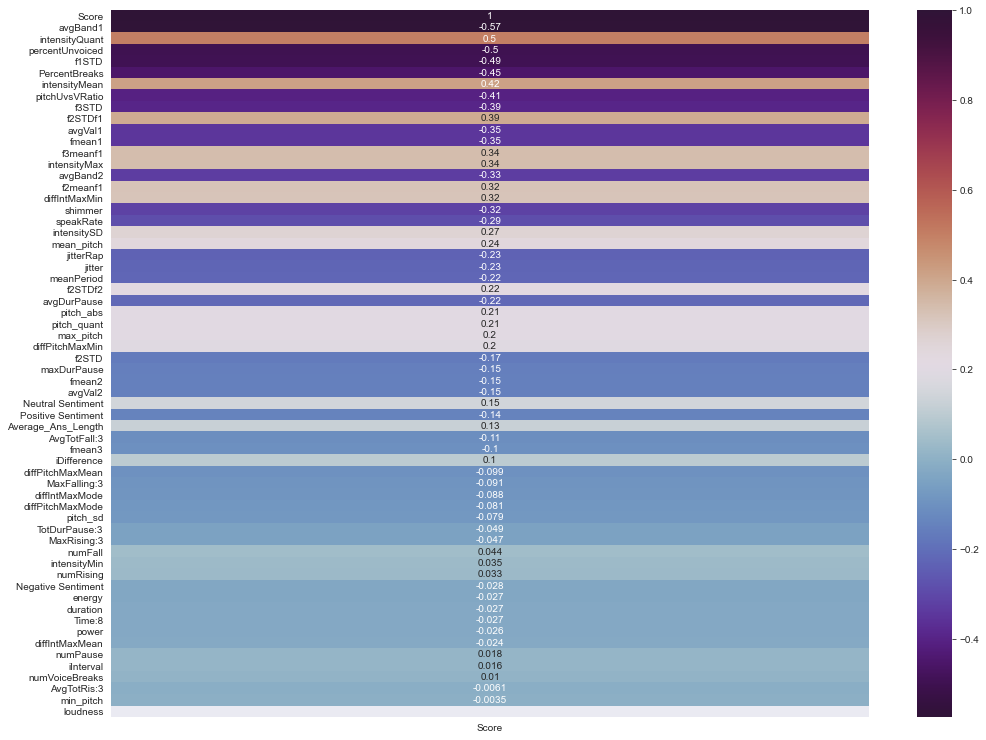

In [169]:
CORR = DF.corr().loc['Score'].to_frame()
CORR = CORR.loc[np.abs(CORR.Score).sort_values(ascending=False).index,:]
sns.heatmap(CORR,annot=True,cmap='twilight_shifted')

In [95]:
from sklearn.feature_extraction.text import CountVectorizer

tfidf = CountVectorizer(stop_words='english',ngram_range=(1,1))
tf_df = tfidf.fit_transform(DF.Text)
tf_df = pd.DataFrame(tf_df.toarray(),columns=tfidf.vocabulary_)

NUMBER_OF_COMPONENTS = 30

svd = TruncatedSVD(NUMBER_OF_COMPONENTS)
decomposed = svd.fit_transform(tf_df)

evr = svd.explained_variance_ratio_
total_var = evr.sum() * 100
cumsum_evr = np.cumsum(evr)

trace1 = {
    "name": "individual explained variance", 
    "type": "bar", 
    'y':evr}
trace2 = {
    "name": "cumulative explained variance", 
    "type": "scatter", 
     'y':cumsum_evr}
data = [trace1, trace2]
layout = {
    "xaxis": {"title": "Principal components"}, 
    "yaxis": {"title": "Explained variance ratio"},
  }
fig = go.Figure(data=data, layout=layout)
fig.update_layout(     title='{:.2f}% of the Dialog Variance Can Be Explained Using {} Words'.format(np.sum(evr)*100,NUMBER_OF_COMPONENTS))
fig.show()

In [96]:
best_fearures = [[tfidf.get_feature_names()[i],svd.components_[0][i]] for i in svd.components_[0].argsort()[::-1]]
worddf = pd.DataFrame(np.array(best_fearures[:NUMBER_OF_COMPONENTS])[:,0]).rename(columns={0:'Word'})
worddf['Explained Variance'] =  np.round(evr*100,2)
worddf['Explained Variance'] =worddf['Explained Variance'].apply(lambda x:str(x)+'%')
app = []
for word in worddf.Word:
    total_count = 0
    for text in DF.Text:
        if text.find(word)!= -1:
            total_count+=1
    app.append(total_count)
worddf['Appeared_On_X_Tweets'] = app
worddf

fig = go.Figure()
fig.add_trace(
    go.Table(
        header=dict(
            values=['<b>Word<b>',"<b>Accountable for X% of Variance<b>",'<b>Appeared On X Sentences<b>'],
            font=dict(size=19,family="Lato"),
            align="center"
        ),
        cells=dict(
            values=[worddf[k].tolist() for k in ['Word',"Explained Variance",'Appeared_On_X_Tweets']],
            align = "center")
    ),
    
)

fig.show()

In [97]:
DEC_DF = pd.DataFrame(decomposed,columns=[f'pc_{i}' for i in range(0,NUMBER_OF_COMPONENTS)])
DEC_DF['Score'] = DF.Score.values
DEC_DF

pc_0       pc_1       pc_2      pc_3       pc_4       pc_5  \
0     8.726903   6.445279  -5.239125  0.391081  -4.949925  -2.066190   
1    59.015942 -33.350081  17.155437 -5.317493  -1.493228  -3.532751   
2    12.933954  11.293380   8.627524  3.049789  -4.794799  -5.531931   
3    14.080507   6.112037  -1.026645  3.248964  -2.174907   3.876025   
4    14.959557  12.439793   4.768435  4.990340   6.153401   0.281638   
..         ...        ...        ...       ...        ...        ...   
133  22.568696  -6.807221   0.442893  1.964016   4.596980  -1.631023   
134  30.772434  -4.029814   1.669926 -0.554191  -7.120027  -3.992911   
135  58.923022  18.869953 -24.450718 -5.146767  -4.190056 -14.255285   
136  42.567564  -7.713327   6.730296 -1.414023 -11.508920  11.629384   
137  41.584593  -0.916083   0.678092  5.826007  -1.626227  14.298708   

         pc_6      pc_7       pc_8      pc_9  ...     pc_21     pc_22  \
0    1.862347  0.379999   2.662921  0.757417  ...  0.783725 -2.907011   
1    6.503490  0.788417  -1.915443  1.690479  ...  0.977293  5.019945   
2   -4.714530 -2.196825   1.894533  7.701879  ... -0.405114 -1.885302   
3   -2.440842  0.669728   0.634270 -3.005766  ... -0.477763 -3.092935   
4   -1.018051 -1.759275   2.428064 -2.734762  ... -1.573675 -0.922840   
..        ...       ...        ...       ...  ...       ...       ...   
133  0.849344  0.745729   0.714023 -0.608751  ... -1.682122 -0.739511   
134 -1.322857  1.110202   1.795192 -4.505110  ... -1.180502 -3.688593   
135 -9.089690 -6.019183 -16.437162  9.259460  ...  2.125716  0.235737   
136 -2.488842  2.251203   1.748493 -0.011643  ...  7.337258 -3.746727   
137 -4.599359 -1.061590  -5.918584 -6.301941  ...  2.954299 -0.710302   

        pc_23     pc_24     pc_25     pc_26     pc_27     pc_28     pc_29  \
0    5.430382  2.225891  0.107093  1.433644 -0.660555 -1.162938  1.970669   
1    1.683070  3.181267 -3.191218  3.591819 -2.941305 -5.252933  3.538588   
2   -3.059169  2.042421  2.175112 -1.684845  1.136245 -0.555109  2.695137   
3   -0.218862 -0.666581  0.206753  0.526321  0.506386  1.204645 -2.627573   
4   -1.420194  0.231151 -3.093405 -1.614923  3.055502 -0.457830 -1.790250   
..        ...       ...       ...       ...       ...       ...       ...   
133  0.379777 -0.137013  3.164590 -1.150839 -2.203957 -0.346638 -0.847740   
134  1.824599 -1.945842  0.475640 -2.137440 -0.422176 -0.799449  1.725335   
135  2.630605  3.236881 -0.272240  0.020458  3.722522  4.166296 -4.488062   
136  2.899026 -5.972950 -0.322887 -0.209956 -2.443403  1.152889 -5.664935   
137 -0.341285  8.927420 -0.363584 -4.173193 -2.317509 -2.595537 -5.023460   

        Score  
0    0.525416  
1    0.341039  
2    0.347818  
3    0.674462  
4    0.265496  
..        ...  
133  0.779364  
134  0.707589  
135  0.629375  
136  0.504305  
137  0.471184  

[138 rows x 31 columns]

In [98]:
DF['um_count'] = DF.Text.apply(lambda x: len(re.findall(r'um',x)))

In [99]:
DF[['um_count','Score']].corr()
# The Number of "um"s isnt directly affecting the overall score given to to the reviewer

um_count     Score
um_count  1.000000 -0.140682
Score    -0.140682  1.000000

<AxesSubplot:title={'center':'Score Distribution'}, xlabel='Score', ylabel='Count'>

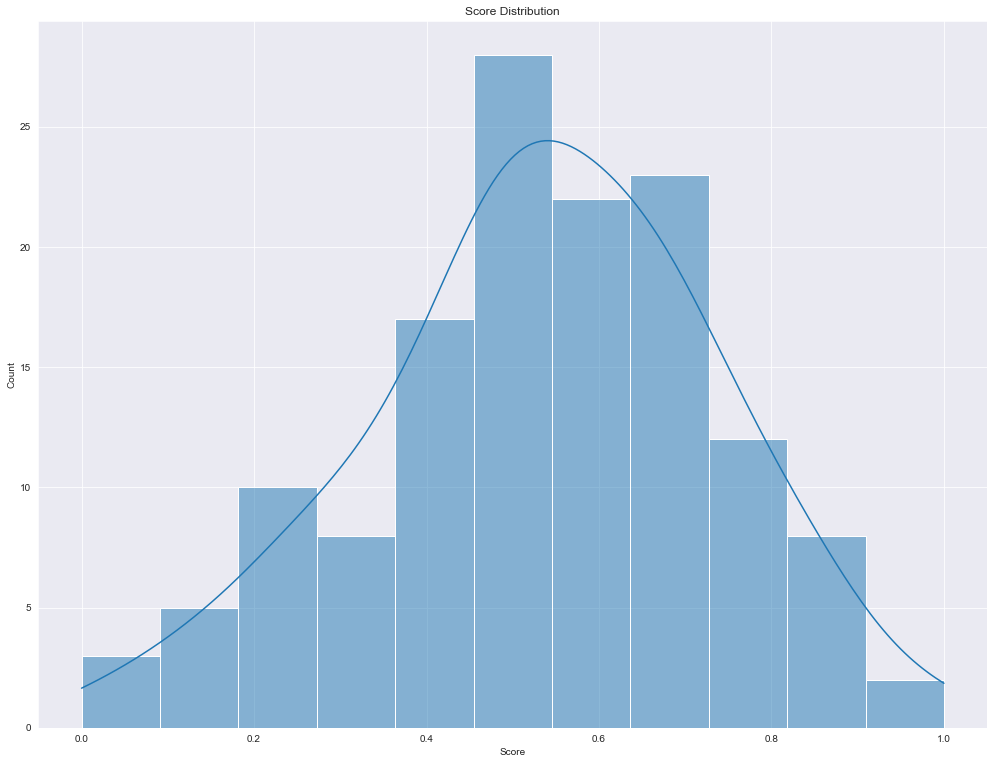

In [100]:
plt.title('Score Distribution')
sns.histplot(DF['Score'],kde=True)

In [101]:
DF['Score_Int'] = pd.cut(DF.Score,5,labels=[1,2,3,4,5])

In [102]:
WCs = []
for i in range(1,6):
    T = ' '.join(DF.query(f'Score_Int == {i}').Text)
    T = [z for z in T.split(' ') if z not in ['um','uh','umm','Um']]
    T = ' '.join(T)
    WCs.append(WordCloud(background_color='white').generate(T))


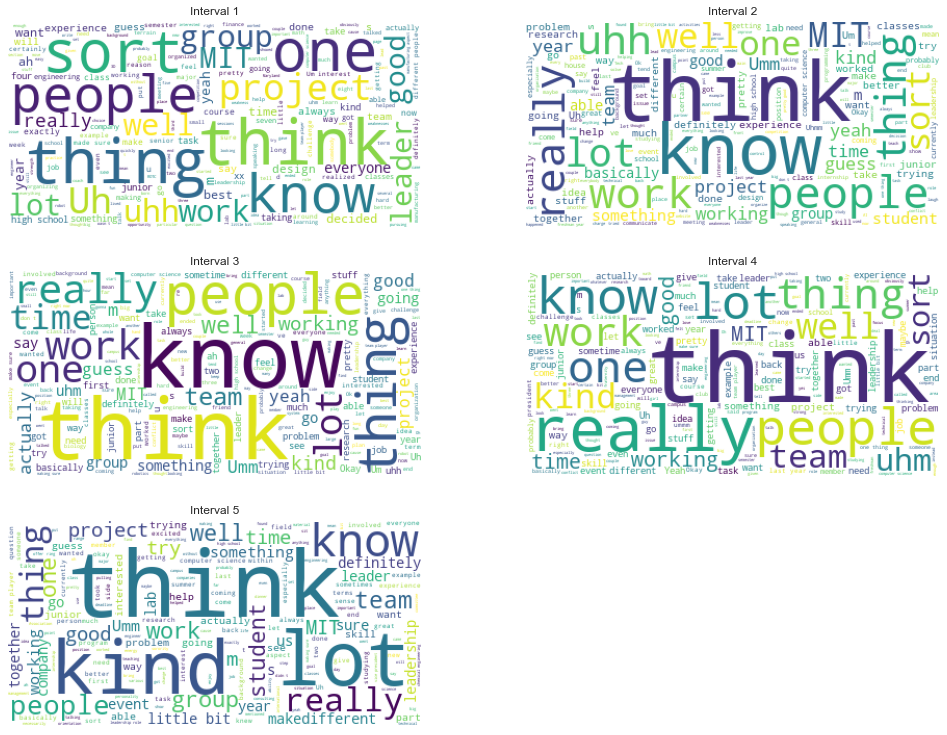

In [103]:
for i in range(1,6):
    plt.subplot(3,2,i)
    plt.title(f'Interval {i}')
    plt.imshow(WCs[i-1])
    plt.axis('off')

In [104]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import Isomap

tfidf = CountVectorizer(stop_words='english',ngram_range=(1,1))
tf_df = tfidf.fit_transform(DF.Text)
#tf_df = pd.DataFrame(tf_df.toarray(),columns=tfidf.vocabulary_)

NUMBER_OF_COMPONENTS = 30

isomap = Isomap(n_neighbors = 2)
decomposed = isomap.fit_transform(tf_df)
DDF = pd.DataFrame(decomposed,columns=['pc_1','pc_2'])
DDF['Score'] = DF['Score'].values
ex.scatter(DDF,x='pc_1',y='pc_2',color='Score')

In [172]:
q_low = DF["Average_Ans_Length"].quantile(0.1)
q_hi  = DF["Average_Ans_Length"].quantile(0.90)

df_filtered = DF[(DF["Average_Ans_Length"] < q_hi) & (DF["Average_Ans_Length"] > q_low)]
df_filtered

Text     Score   duration  \
p1    Im pretty good. ok  uhm  so have you looked at...  0.525416  34.186796   
p10   Great  how about you? I'm a little [???] by th...  0.341039  77.378613   
p11   Uhh  I’m a junior at MIT  uhh I’m double major...  0.347818  50.431333   
p12   I'm good  how are you? Ok  so  I'm a Junior at...  0.674462  35.910442   
p13   Good. Ok  umm  I'm currently a junior at M.I.T...  0.265496  51.049858   
...                                                 ...       ...        ...   
pp81  Um  I am a sophomore at MIT. Um  I'm studying ...  0.901773  50.915183   
pp83  Um  pretty good  pretty good. Getting busy wit...  0.779364  28.907788   
pp84   Good thank you  how are you?  Alright  well  ...  0.707589  52.262092   
pp86  In my technical background  um. Been a junior ...  0.504305  76.643092   
pp89  Mhmm uh so is it all right if I kind of talk a...  0.471184  80.570025   

        energy     power  min_pitch   max_pitch  mean_pitch   pitch_sd  \
p1    0.011510  0.000333  78.064294  340.516454  129.307639  25.242104   
p10   0.032118  0.000404  74.787772  345.935347  112.955696  25.915806   
p11   0.007220  0.000134  73.605587  384.004524  186.524402  35.911648   
p12   0.008005  0.000205  73.706414  326.346399  181.006693  40.494458   
p13   0.001618  0.000029  75.141598  332.370097  181.156105  41.081781   
...        ...       ...        ...         ...         ...        ...   
pp81  0.011988  0.000230  70.843019  397.952348  217.683136  40.541323   
pp83  0.003143  0.000108  75.106137  375.449500  240.799891  47.024393   
pp84  0.008353  0.000146  77.471544  393.760530  209.208918  28.918232   
pp86  0.010589  0.000132  78.332326  353.811432  128.650234  33.885335   
pp89  0.019874  0.000245  72.692857  367.095029  141.030662  26.478476   

       pitch_abs  ...  MaxFalling:3  AvgTotRis:3  AvgTotFall:3  numRising  \
p1    176.176383  ...      186.2474      20.4186       13.8120       59.2   
p10   166.265804  ...      222.0450      23.4998       17.2176      114.4   
p11   226.353579  ...      203.0714      24.3098       15.5036       84.4   
p12   266.110211  ...      148.5378      25.6070       27.0372       53.4   
p13   249.154938  ...      166.8634      31.6820       19.6138       77.4   
...          ...  ...           ...          ...           ...        ...   
pp81  293.708701  ...      192.5864      30.3124       20.0466       79.0   
pp83  306.047489  ...      196.4858      34.4062       24.2604       40.4   
pp84  255.670407  ...      199.9002      24.0986       13.9570       81.6   
pp86  175.557862  ...      198.5142      24.0148       20.5388       92.6   
pp89  152.971090  ...      217.8448      18.9770        9.1982      115.6   

          numFall  loudness  Positive Sentiment  Neutral Sentiment  \
p1    2885.361924       NaN            0.136001           0.854001   
p10   4560.598782       NaN            0.140001           0.833001   
p11   4359.223573       NaN            0.092001           0.881001   
p12   4160.100665       NaN            0.146001           0.836001   
p13    420.371424       NaN            0.133001           0.812001   
...           ...       ...                 ...                ...   
pp81  4660.506791       NaN            0.191001           0.788001   
pp83  2177.129326       NaN            0.156001           0.835001   
pp84  3378.566960       NaN            0.234001           0.743001   
pp86  5936.542073       NaN            0.216001           0.747001   
pp89  4979.958804       NaN            0.181001           0.800001   

      Negative Sentiment  Average_Ans_Length  
p1              0.011001           73.250000  
p10             0.026001           70.823529  
p11             0.027001          122.833333  
p12             0.018001           54.666667  
p13             0.054001           73.111111  
...                  ...                 ...  
pp81            0.021001          155.000000  
pp83            0.009001           38.230769  
pp84        

In [174]:
fig = ex.scatter(DF,x='intensityQuant',y='Score',trendline='ols')
fig.show()

# Bipopulation Experiment

In [207]:
b_pop = DF[DF['Score'] < DF['Score'].mean()-1.5*DF['Score'].std() ].copy()
g_pop = DF[DF['Score'] > DF['Score'].mean()+1.5*DF['Score'].std() ].copy()


S = pd.DataFrame(index=['BadPop','GoodPop'],columns=['Size','Mean Score','STD Score'])
S.loc['BadPop','Size'] = b_pop.shape[0] 
S.loc['GoodPop','Size'] = g_pop.shape[0] 
S.loc['BadPop','Mean Score'] = b_pop['Score'].mean() 
S.loc['GoodPop','Mean Score'] = g_pop['Score'].mean() 
S.loc['BadPop','STD Score'] = b_pop['Score'].std() 
S.loc['GoodPop','STD Score'] = g_pop['Score'].std() 
S

Size Mean Score  STD Score
BadPop     9   0.114586  0.0669669
GoodPop    8   0.901435  0.0605456

In [208]:
#normlize
def convert_to_z_score(ser):
    z = (ser -ser.mean())/ser.std()
    return z
for col in b_pop.columns[1:]:
    b_pop[col] = convert_to_z_score(b_pop[col])
    g_pop[col] = convert_to_z_score(g_pop[col])


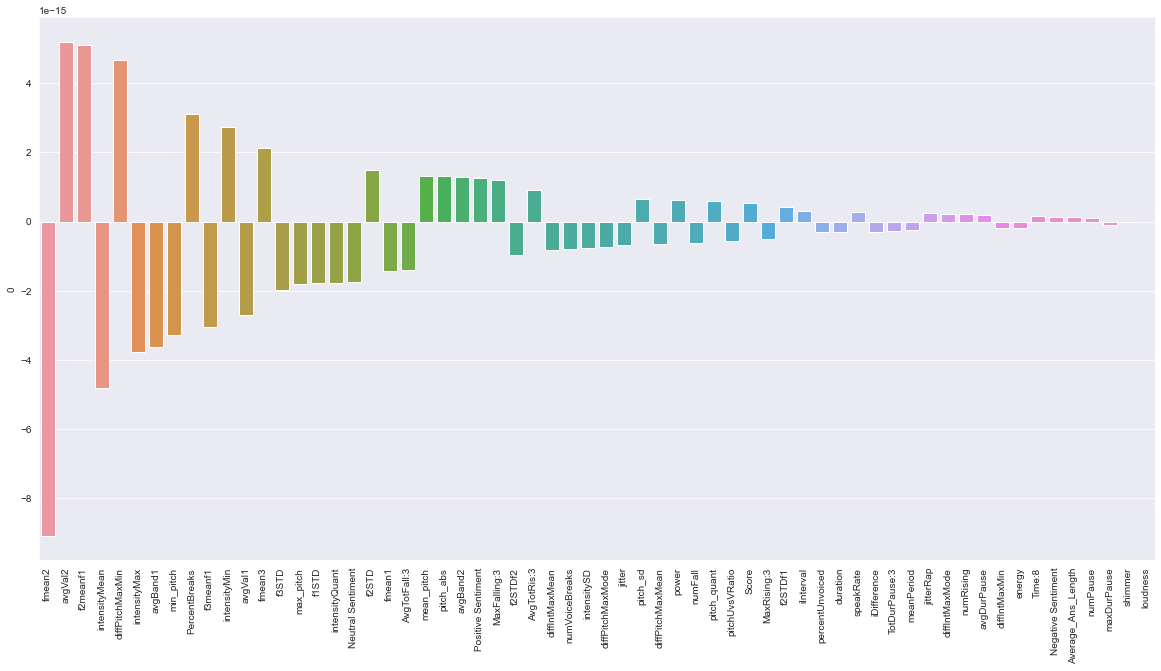

In [221]:
diff_df = (g_pop.mean()-b_pop.mean()).sort_values(ascending=False).to_frame()
diff_df = diff_df.loc[np.abs(diff_df[0]).sort_values(ascending=False).index,:]
plt.figure(figsize=(20,10))
ax = sns.barplot(x=diff_df.index,y=diff_df[0])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [253]:
b_pop['Pop'] = 0
g_pop['Pop'] = 1

bi_df= pd.concat([b_pop,g_pop],axis=0)
bi_df = bi_df.drop(columns=['Text'])
bi_df = bi_df.fillna(0)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

LR_P = Pipeline(steps=[('lr',LogisticRegression())])

cross_val_score(LR_P,bi_df.iloc[:,1:-1],bi_df.iloc[:,-1].values,cv=5,scoring='f1')

array([0., 0., 0., 0., 0.])

In [254]:
LR = DecisionTreeClassifier()
LR.fit(bi_df.iloc[:,1:-1],bi_df.iloc[:,-1])
LR.predict(bi_df.iloc[:,1:-1])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

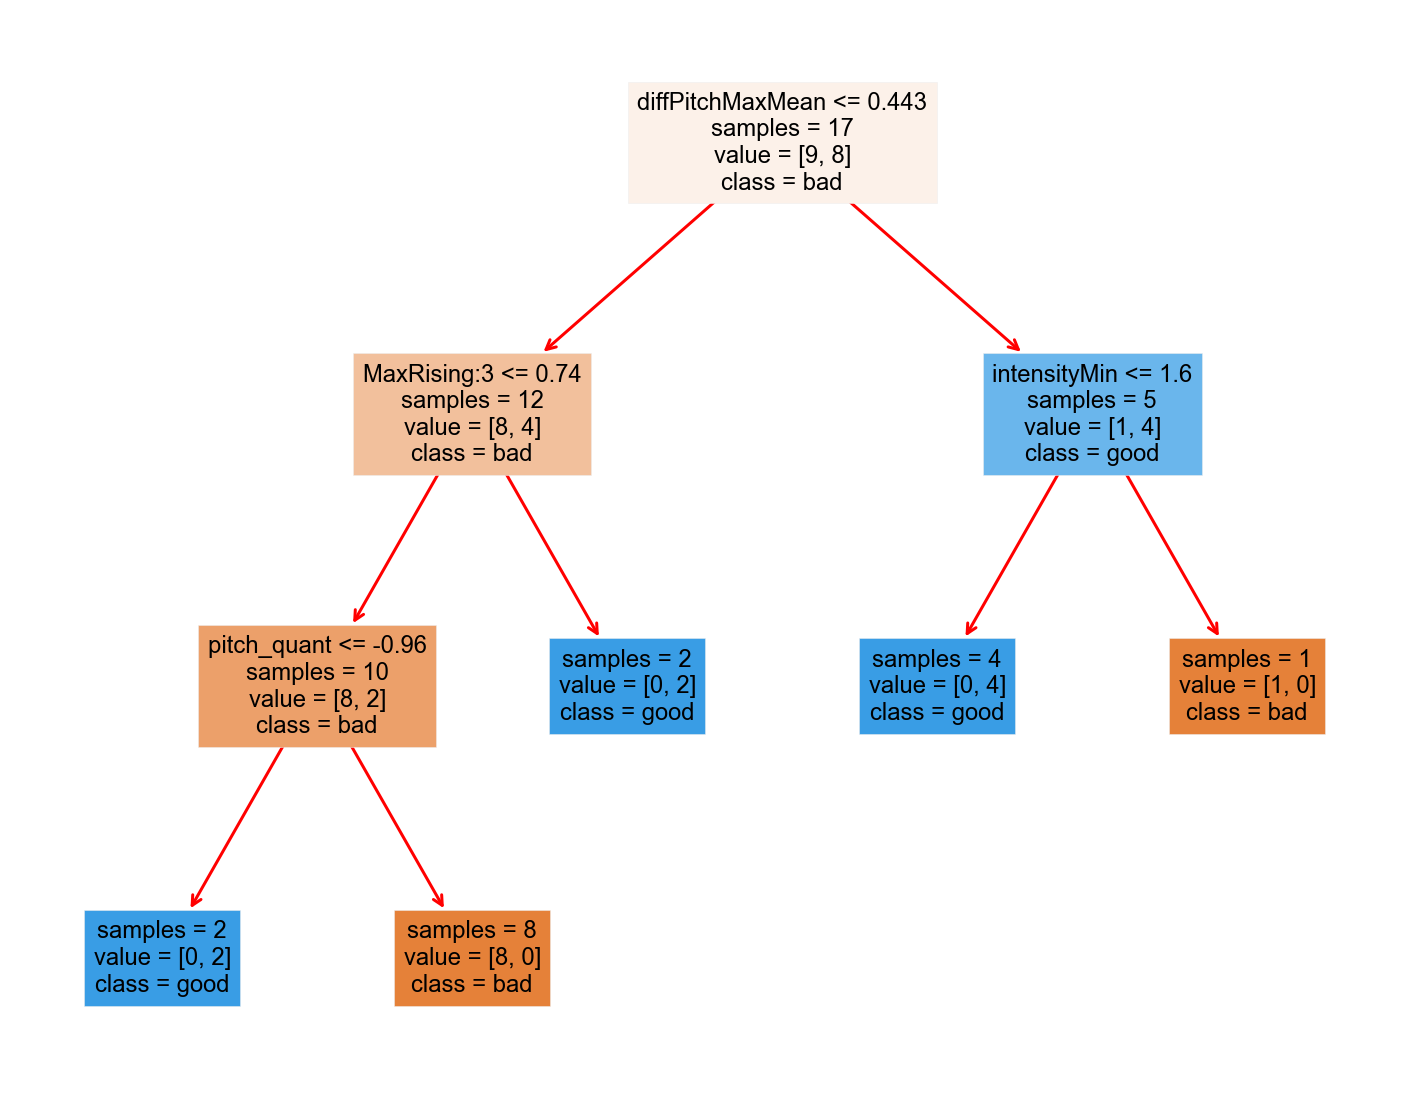

In [276]:
from sklearn import tree
import matplotlib as mpl

plt.style.use('bmh')
mpl.rcParams['text.color'] = 'black'

fig = plt.figure(figsize=(25,20))
out = tree.plot_tree(LR, 
                   feature_names=bi_df.iloc[:,1:-1].columns,  
                   class_names=['bad','good'],
                   filled=True,impurity=False)


for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('red')
        arrow.set_linewidth(3)

In [300]:

isomap = Isomap(n_components=3)
decomposed = isomap.fit_transform(bi_df.iloc[:,1:-1])
DDF = pd.DataFrame(decomposed,columns=['pc_1','pc_2','pc_3'])
DDF['POP'] = bi_df['Pop'].values
ex.scatter(DDF,x='pc_1',y='pc_2',color='POP')

In [279]:
bi_df

Score  duration    energy     power  min_pitch  max_pitch  \
p30  -1.711087 -0.631796 -0.607466  0.135719   0.472592   0.520554   
p47   1.436418 -0.463935  0.646085  0.731162  -0.804590   0.095086   
p52   0.465133  0.052459 -0.194684 -0.324102  -0.291397  -0.345080   
p61   0.766950 -1.020392 -1.568971 -1.190941   0.950119  -1.719570   
p69   0.271344  0.383951  0.281899 -0.174303  -0.603217   0.163994   
pp47  0.330412 -0.755278 -0.816877 -0.302633   2.034764  -0.802349   
pp48  0.265773 -0.397020  1.944663  2.209117   0.048877   0.353223   
pp6  -0.534528  2.269239 -0.102894 -0.950597  -0.870122  -0.215734   
pp69 -1.290414  0.562773  0.418245 -0.133422  -0.937026   1.949876   
p32  -0.772153  1.306820  1.579016  0.754026   0.813292   0.642161   
p57   1.627951  0.592410 -1.056214 -1.291417  -1.158366  -1.499851   
p84  -1.032877  0.946603 -0.324113 -0.749315   0.407166   0.240514   
pp14 -0.703772 -0.809175  0.875363  1.794448  -0.197416   0.039142   
pp24 -0.430602 -1.693847 -0.845809 -0.060820   1.761977   0.846410   
pp33 -0.106455  0.411181  0.973382  0.573378   0.172146   0.628651   
pp57  1.412318 -0.561401 -0.860614 -0.764319  -0.758061  -1.624259   
pp81  0.005591 -0.192592 -0.341012 -0.255981  -1.040737   0.727233   

      mean_pitch  pitch_sd  pitch_abs  pitch_quant  ...  AvgTotRis:3  \
p30     1.652545  1.273957   0.517299     1.392816  ...     0.082605   
p47    -0.125371 -0.249059  -0.062480    -0.215554  ...     0.027033   
p52    -0.719117 -1.041787  -0.833923    -0.504400  ...    -0.758146   
p61     1.749846 -0.216005   0.450135     1.979133  ...    -0.057843   
p69    -0.390550  1.471906   1.708195    -0.760403  ...     1.946994   
pp47   -0.236173 -0.667363  -0.854796    -0.185247  ...    -0.926392   
pp48   -0.295341  0.407243  -0.086472    -0.352596  ...     0.373604   
pp6    -0.675143 -1.470818  -1.607103    -0.369431  ...    -1.436899   
pp69   -0.960696  0.491926   0.769145    -0.984318  ...     0.749045   
p32     0.868294  1.023103   0.812158     1.026392  ...     1.165054   
p57    -1.367818 -0.736501   0.001451    -1.375591  ...    -0.897552   
p84    -0.179611 -1.072362  -0.405886     0.184087  ...    -0.418952   
pp14   -0.654681  0.893164  -1.281187    -0.829789  ...    -0.313443   
pp24    0.434489 -0.203062  -0.931780     0.292789  ...    -0.146329   
pp33    1.424054  1.460967   1.886694     1.223704  ...     1.417405   
pp57   -1.145509 -1.104220  -0.267738    -1.158745  ...    -1.453774   
pp81    0.620782 -0.261089   0.186287     0.637154  ...     0.647591   

      AvgTotFall:3  numRising   numFall  loudness  Positive Sentiment  \
p30       0.268068  -0.802306 -0.715633       0.0           -1.056676   
p47      -0.067992  -0.417951 -0.259775       0.0           -0.432711   
p52      -0.673282   0.156020 -0.014256       0.0            1.051894   
p61      -0.280624  -0.961172 -1.195143       0.0           -0.260583   
p69       1.907469   0.340510  0.826988       0.0            0.105189   
pp47     -1.042362  -0.643439 -0.900307       0.0            1.008862   
pp48      0.286996  -0.551194 -0.609315       0.0            0.836734   
pp6      -1.318248   2.231537  1.520273       0.0           -1.852768   
pp69      0.919976   0.647994  1.347168       0.0            0.600058   
p32       1.422770   1.169547  0.732802       0.0           -0.879955   
p57      -0.370110   0.825716  1.558805       0.0           -0.832390   
p84       0.110853   0.909069  0.310528       0.0           -0.856173   
pp14      1.087689  -1.216433 -0.484687       0.0            1.783693   
pp24     -0.580340  -1.612360 -1.903734       0.0            0.356739   
pp33     -0.246043   0.117215  0.131597       0.0            0.428086   
pp57     -1.768582  -0.018233 -0.190561       0.0           -0.808608   
pp81      0.343762  -0.174520 -0.154749       0.0            0.808608   

      Neutral Sentiment  Negative Sentiment  Average_Ans_Length  Pop  
p30            1.038421            0.138529           -0.886388  

In [237]:
results = ex.get_trendline_results(fig)
results = results.iloc[0]["px_fit_results"].summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     46.02
Date:                Wed, 28 Apr 2021   Prob (F-statistic):           3.29e-10
Time:                        13:09:50   Log-Likelihood:                 46.346
No. Observations:                 138   AIC:                            -88.69
Df Residuals:                     136   BIC:                            -82.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0469      0.234     -4.481      0.000      -1.509      -0.585
x1             0.0316      0.005      6.784      0.000       0.022       0.041
==============================================================================
Omnibus:                        1.401   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.496   Jarque-Bera (JB):                1.245
Skew:                          -0.068   Prob(JB):                        0.537
Kurtosis:                       2.555   Cond. No.                         791.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
DF.columns

Index(['Text', 'Score', 'duration', 'energy', 'power', 'min_pitch',
       'max_pitch', 'mean_pitch', 'pitch_sd', 'pitch_abs', 'pitch_quant',
       'pitchUvsVRatio', 'Time:8', 'iDifference', 'diffPitchMaxMin',
       'diffPitchMaxMean', 'diffPitchMaxMode', 'intensityMin', 'intensityMax',
       'intensityMean', 'intensitySD', 'intensityQuant', 'diffIntMaxMin',
       'diffIntMaxMean', 'diffIntMaxMode', 'avgVal1', 'avgVal2', 'avgBand1',
       'avgBand2', 'fmean1', 'fmean2', 'fmean3', 'f2meanf1', 'f3meanf1',
       'f1STD', 'f2STD', 'f3STD', 'f2STDf1', 'f2STDf2', 'jitter', 'shimmer',
       'jitterRap', 'meanPeriod', 'percentUnvoiced', 'numVoiceBreaks',
       'PercentBreaks', 'speakRate', 'numPause', 'maxDurPause', 'avgDurPause',
       'TotDurPause:3', 'iInterval', 'MaxRising:3', 'MaxFalling:3',
       'AvgTotRis:3', 'AvgTotFall:3', 'numRising', 'numFall', 'loudness',
       'Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment',
       'um_count', 'Score_Int'],
      dtype=

In [122]:
questions = []
anwsers   = []

for index,row in trans_c.iterrows():
    text =row.Text
    splited = text.split('|')
    for i in splited:
        if i.find('Interviewer') == -1:
            start = i.find('Interviewee: ')+13
            
            anwsers.append(i[start:])
        else:
            start = i.find('Interviewer: ')+13
            questions.append(i[start:])

In [123]:
dialog_dict = {i:j for i,j in zip(questions,anwsers)}

In [124]:
dialog_dict

{'So how are you doing?': 'Im pretty good.',
 'Ok well  so please tell me about yourself.': 'ok  uhm  so have you looked at my resume or should I  alright  so I guess ah  I am course 6-7 here at M.I.T  ah which is computational biology  so its a mix of computers  science and biology and actually thats where my interest lie in applying like algorithmic kinda software engineering too datasets dealing with genomics and biology.  Uhm some of that activities that you do out side of school  include Camp Kesem which is a summer camp that we run for completely free for kids whose parents have cancer  as well as ah amphibious achievement  which is ah a high school tutoring program for inner city kids in Boston  ',
 ' mhhmm': 'So ah  my interest kinda laid both in a little bit of the health care  I imagined I was going be a Doctor growing up  and then it came down to the tee and Im like  well I can do engineering and still apply and do the same things and help a lot more people.',
 'So please te

In [131]:
for i in nltk.FreqDist(anwsers):
    print(i)


Yeah.
Okay.
Good.
Yep.
Thank you.
I'm good  how are you?
 Good  how are you?
Mmhmm.
Thanks.
I'm good. How are you?
How are you?
All right.
Sure.
Pretty good  how are you?
Yup.
Yeah. 
Yeah  sure.
Yes.
So.
Mhmm.
I'm doing well  how are you?
Im pretty good.
ok  uhm  so have you looked at my resume or should I  alright  so I guess ah  I am course 6-7 here at M.I.T  ah which is computational biology  so its a mix of computers  science and biology and actually thats where my interest lie in applying like algorithmic kinda software engineering too datasets dealing with genomics and biology.  Uhm some of that activities that you do out side of school  include Camp Kesem which is a summer camp that we run for completely free for kids whose parents have cancer  as well as ah amphibious achievement  which is ah a high school tutoring program for inner city kids in Boston  
So ah  my interest kinda laid both in a little bit of the health care  I imagined I was going be a Doctor growing up  and th

Text     Score   duration  \
p1    Im pretty good. ok  uhm  so have you looked at...  0.525416  34.186796   
p10   Great  how about you? I'm a little [???] by th...  0.341039  77.378613   
p11   Uhh  I’m a junior at MIT  uhh I’m double major...  0.347818  50.431333   
p12   I'm good  how are you? Ok  so  I'm a Junior at...  0.674462  35.910442   
p13   Good. Ok  umm  I'm currently a junior at M.I.T...  0.265496  51.049858   
...                                                 ...       ...        ...   
pp83  Um  pretty good  pretty good. Getting busy wit...  0.779364  28.907788   
pp84   Good thank you  how are you?  Alright  well  ...  0.707589  52.262092   
pp85  Okay  well I'm a junior here at MIT. Umm  I'm ...  0.629375  62.115933   
pp86  In my technical background  um. Been a junior ...  0.504305  76.643092   
pp89  Mhmm uh so is it all right if I kind of talk a...  0.471184  80.570025   

        energy     power  min_pitch   max_pitch  mean_pitch   pitch_sd  \
p1    0.011510  0.000333  78.064294  340.516454  129.307639  25.242104   
p10   0.032118  0.000404  74.787772  345.935347  112.955696  25.915806   
p11   0.007220  0.000134  73.605587  384.004524  186.524402  35.911648   
p12   0.008005  0.000205  73.706414  326.346399  181.006693  40.494458   
p13   0.001618  0.000029  75.141598  332.370097  181.156105  41.081781   
...        ...       ...        ...         ...         ...        ...   
pp83  0.003143  0.000108  75.106137  375.449500  240.799891  47.024393   
pp84  0.008353  0.000146  77.471544  393.760530  209.208918  28.918232   
pp85  0.007095  0.000112  71.071074  367.137037  108.901779  33.320900   
pp86  0.010589  0.000132  78.332326  353.811432  128.650234  33.885335   
pp89  0.019874  0.000245  72.692857  367.095029  141.030662  26.478476   

       pitch_abs  ...  AvgTotRis:3  AvgTotFall:3  numRising      numFall  \
p1    176.176383  ...      20.4186       13.8120       59.2  2885.361924   
p10   166.265804  ...      23.4998       17.2176      114.4  4560.598782   
p11   226.353579  ...      24.3098       15.5036       84.4  4359.223573   
p12   266.110211  ...      25.6070       27.0372       53.4  4160.100665   
p13   249.154938  ...      31.6820       19.6138       77.4   420.371424   
...          ...  ...          ...           ...        ...          ...   
pp83  306.047489  ...      34.4062       24.2604       40.4  2177.129326   
pp84  255.670407  ...      24.0986       13.9570       81.6  3378.566960   
pp85  194.309486  ...      17.9250       16.1200      125.4  8216.958280   
pp86  175.557862  ...      24.0148       20.5388       92.6  5936.542073   
pp89  152.971090  ...      18.9770        9.1982      115.6  4979.958804   

      loudness  Positive Sentiment  Neutral Sentiment  Negative Sentiment  \
p1         NaN            0.136001           0.854001            0.011001   
p10        NaN            0.140001           0.833001            0.026001   
p11        NaN            0.092001           0.881001            0.027001   
p12        NaN            0.146001           0.836001            0.018001   
p13        NaN            0.133001           0.812001            0.054001   
...        ...                 ...                ...                 ...   
pp83       NaN            0.156001           0.835001            0.009001   
pp84       NaN            0.234001           0.743001            0.023001   
pp85       NaN            0.248001           0.736001            0.016001   
pp86       NaN            0.216001           0.747001            0.036001   
pp89       NaN            0.181001           0.800001            0.019001   

      um_count  Score_Int  
p1           2          3  
p10         60          2  
p11          8          2  
p12          7          4  
p13          9          2  
...        ...        ...  
pp83        12          4  
pp84        13          4  
pp85        16          4  
pp86        10          3  
pp89        22          3  

[138 rows x 64 columns]